In [75]:
# Import numpy, pandas, matpltlib.pyplot, sklearn modules and seaborn
import matplotlib.pyplot as plt
from matplotlib import colors as plt_colors
%matplotlib inline
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
plt.style.use('ggplot')
import seaborn as sns
# Import KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier
# Import DecisionTreeClassifier from sklearn.tree
from sklearn.tree import DecisionTreeClassifier
# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import roc_curve, auc
# For Feature Explanations
import shap
# load JS visualization code to notebook
shap.initjs()

In [2]:
# Set the list of features to include in Machine Learning
feature_lst=[
    'Source', 'Severity','Start_Lng','Start_Lat','Distance(mi)',
    'Side','City','County','State','Timezone','Temperature(F)',
    'Humidity(%)','Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
    'Weather_Condition','Amenity','Bump','Crossing','Give_Way',
    'Junction','No_Exit','Railway','Roundabout','Station','Stop',
    'Traffic_Calming','Traffic_Signal','Turning_Loop',
    'Sunrise_Sunset','Hour','Weekday', 
    'previous_1', 'previous_2', 'previous_3',
]

# Configurations
def train_model_for(state='CA'):
    # Load Dataset
    df = pd.read_csv(f'../output/accident_data_{state}.csv')
    # Feature Extraction & Preprocessing
    ## Select the dataset to include only the selected features
    df_sel=df[feature_lst].copy()
    # Drop null values
    df_sel.dropna(subset=df_sel.columns[df_sel.isnull().mean()!=0], how='any', axis=0, inplace=True)
    df_state = df_sel.drop('State', axis=1)
    # Generate dummies for categorical data
    df_train = pd.get_dummies(df_state,drop_first=True)
    # Set the target for the prediction
    target='Severity'
    # Create arrays for the features and the response variable
    # set X and y
    y = df_train[target] >= 3
    X = df_train.drop(target, axis=1)
    # Split the data set into training and testing data sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)
    # Create Model
    model = RandomForestClassifier()
    # Train the model
    model.fit(X_train[:1000], y_train[:1000])
    # Predict using model
    y_pred = model.predict(X_test)
    # Get the accuracy score
    acc = accuracy_score(y_test, y_pred)
    print("[Random Forest Classifier] accuracy_score: {:.3f}.".format(acc))
    print(classification_report(y_test, y_pred))
    return model, X_test, y_test, y_pred

In [3]:
model = {
    'CA': None,
    'TX': None,
    'SC': None,
    'FL': None,
    'NC': None,
}

for state in model.keys():
    model[state] = train_model_for(state)

[Random Forest Classifier] accuracy_score: 0.874.
              precision    recall  f1-score   support

       False       0.89      0.96      0.92     26692
        True       0.78      0.57      0.66      7285

    accuracy                           0.87     33977
   macro avg       0.84      0.76      0.79     33977
weighted avg       0.87      0.87      0.87     33977

[Random Forest Classifier] accuracy_score: 0.846.
              precision    recall  f1-score   support

       False       0.86      0.94      0.90      9671
        True       0.77      0.57      0.66      3335

    accuracy                           0.85     13006
   macro avg       0.82      0.76      0.78     13006
weighted avg       0.84      0.85      0.84     13006

[Random Forest Classifier] accuracy_score: 0.903.
              precision    recall  f1-score   support

       False       0.93      0.95      0.94      8568
        True       0.76      0.69      0.73      1948

    accuracy                    

In [4]:
# explain the model's predictions using SHAP
explainer = {}

for state in model.keys():
    explainer[state] = shap.TreeExplainer(model[state][0])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [133]:
def summary_plot(state, n_samples=100):
    fig = plt.gcf()
    sample = model[state][1].sample(n=n_samples)
    shap_values = explainer[state].shap_values(sample)
    class_names = ['High Severity' if c else 'Low Severity' for c in model[state][0].classes_]
    # set RGB tuple per class
    colors = [(0, 0, 1), (1, 0, 0)]
    # get class ordering from shap values
    class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])
    # create listed colormap
    cmap = plt_colors.ListedColormap(np.array(colors)[class_inds])
    shap.summary_plot(shap_values, sample,  color=cmap, class_names=class_names, show=False, plot_size=(10, 6))
    plt.tight_layout()
    plt.savefig(f"../output/imgs/summary_plot_{state.lower()}.png", format='png')

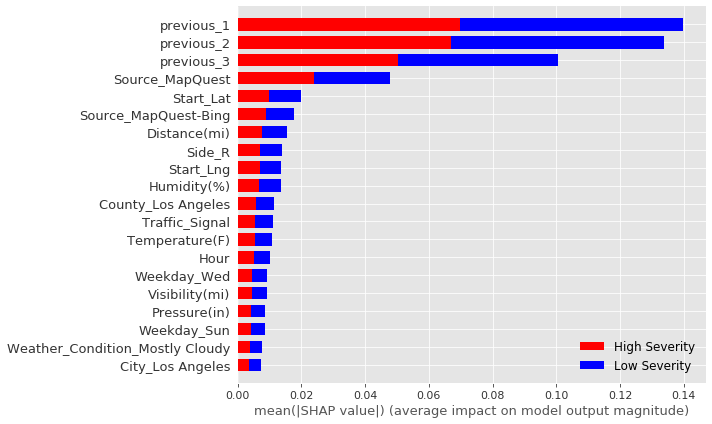

In [134]:
summary_plot('CA')

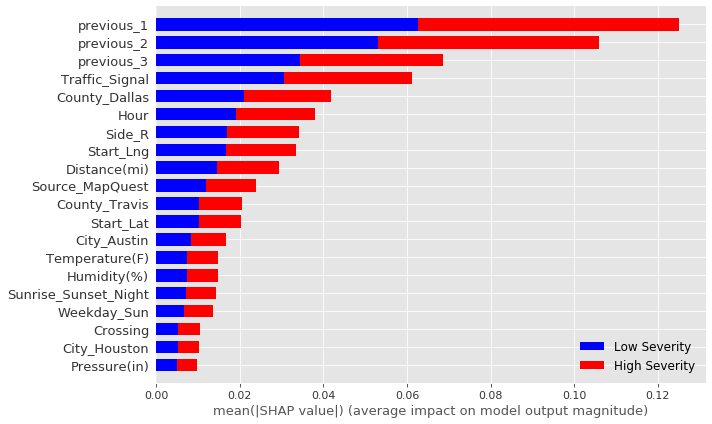

In [135]:
summary_plot('TX')

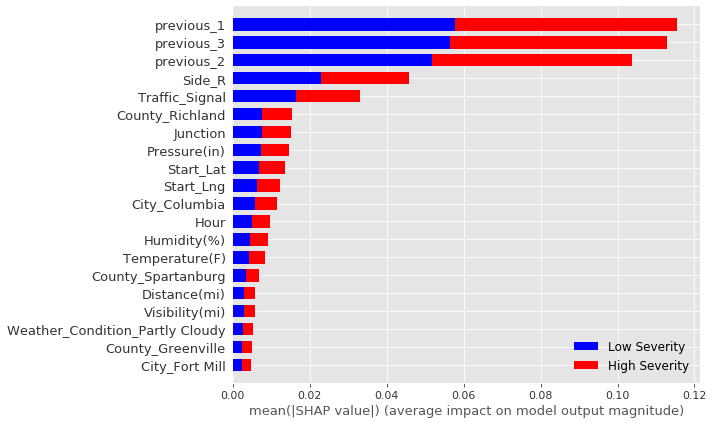

In [136]:
summary_plot('SC')

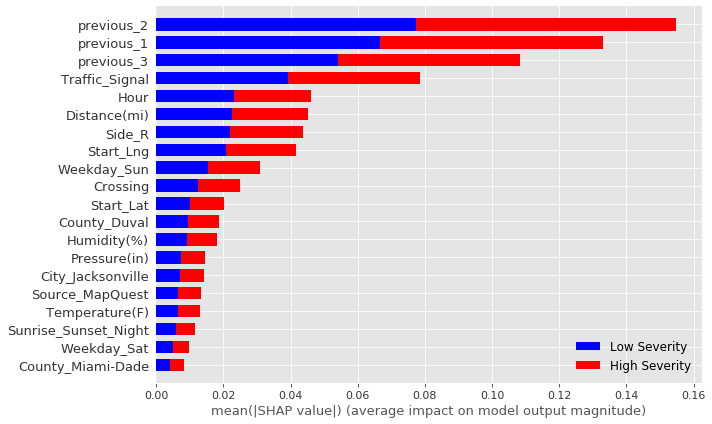

In [137]:
summary_plot('FL')

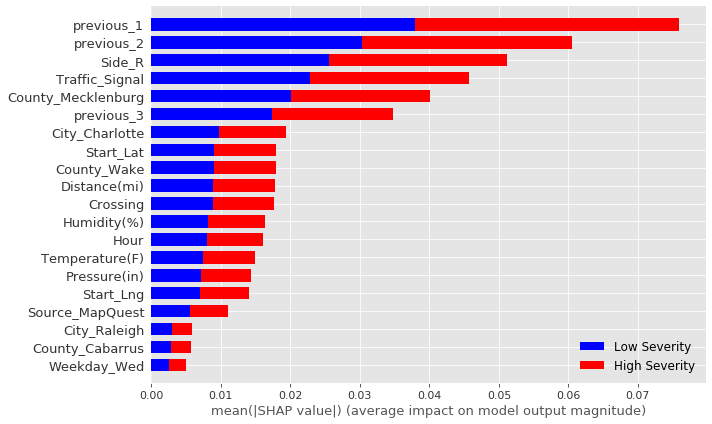

In [139]:
summary_plot('NC')